# Case Study 5: Imputation

#### Steven Hayden, Kevin Mendonsa, Joe Schueder, Nicole Wittlin

## Introduction

The Commonwealth of Massachusetts collects and analyzes myriad data about local communities. Some data is obtained through the Census study every ten years, while other data is collected at the local, county, or state level on a more regular basis. As the lead team of analysts, we are often merging, collating, aggregating, and analyzing data to solve specific questions asked by state agencies.

Recently, we have noticed a disturbing trend. The amount and quality of data collection by several agencies has been declining. More and more, we are seeing data missing from collection reports: sometimes with a discernible patterns; other times, seemingly at random. This, of course, has an impact on our work to build accurate predictive models to address key questions from different agencies. Before escalating the data collection issue to the leadership of other agencies and insisting on more stringent collection methods, we first want to assess how much of an impact the missing data is having on our prediction models. We've designed the following exercise with the Boston Housing data set to explore different levels of missingness and imputation strategies before making our recommendation.

In [1]:
import warnings
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from ml_metrics import rmse

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis 

For this exercise, we are using the Boston Housing dataset, which was compiled in the late 1970s to explore if people would pay more for cleaner air. It is based on 1970 census tract data from the Boston Standard Metropolitan Statistical Area and represents key characteristics of approximately 500 houses corresponding to each tract. Data was downloaded from sklearn's standard datasets. We selected this data because it includes information from several different agencies and the fact that it is historical (i.e. no current employees collected this data). Our attempt is to show a neutral example.

The data has 13 numeric or categorical variables that describe a variety of characteristics related to homes: community details related crime rate, proximity to businesses, highways, and key employment centers, student-teacher ratio, population demographics; and details about the property related to zoning, age, occupancy, size, proximity to the Charles River, taxes, and concentration of nitric oxides. The target prediction variable is the Median Value of each house. The data only represents owner-occupied properties. 

**Since our goal is to study data missingness and imputation, we did not conduct extensive exploratory data analysis.** A complete data dictionary is below. Box plots, pair plots, and a complete analysis of training and test sets can be found in the Appendix. 

However, there are a few key points to note about this data. We determined that there is **no missing data** from the original set - a perfect fit for the objective of the exercise. It is also important to highlight the **house prices are in thousands of dollars.** The Census Bureau censored the data and limited prices to be between five thousand and fifty thousand dollars.
Lastly, we reviewed the correlation matrix to assess the **relationships between variables**. (*Correlation matrix below*) There are several relationships of note:

   - Positive Correlations
        - Tax/Rad (0.91)
        - Indus/Nox (0.76)
        - Nox/Age (0.73)
        - Indus/Tax (0.72)
        
   - Negative Correlations
        - Nox/Dis (-0.77)
        - Age/Dis (-0.75)
        - LSTAT / MEDV (-0.74)

**Data Dictionary**

| Variable | Description |
|-|-|
| CRIM | per capita crime rate by town |
| ZN | proportion of residential land zoned for lots over 25,000 sq ft |
| INDUS | proportion of non-retail business acres per town |
| CHAS | Charles River dummy variable (= 1 if tract bounds river; otherwise 0) |
| NOX | nitric oxides concentration (parts per 10 million) |
| RM | average number of rooms per dwelling |
| AGE | proportion of owner-occupied units build prior to 1940 |
| DIS | weighted distances to five Boston employment centers |
| RAD | index of accessibility to radial highways |
| TX | full-value property-tax rate per ten-thousand dollars |
| PTRATIO | pupil-teach ratio by town |
| B | weighted proportion metric of African Americans (Black residents) by town |
| LSTAT | percentage of population considered of lower status |
| MEDV | (Target) median value of owner-occupied homes in $1000's |

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

**Data Summary**

In [3]:
#https://www.engineeringbigdata.com/boston-dataset-scikit-learn-machine-learning-in-python/
bostondf = pd.DataFrame(boston.data)
#bostondf.head()
bostondf.columns = boston.feature_names
bostondf['MEDV'] = boston.target
bostondf.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

**Check for Missing Values**

In [4]:
bostondf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


**Basic Statistical Measures**

In [5]:
bostondf.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

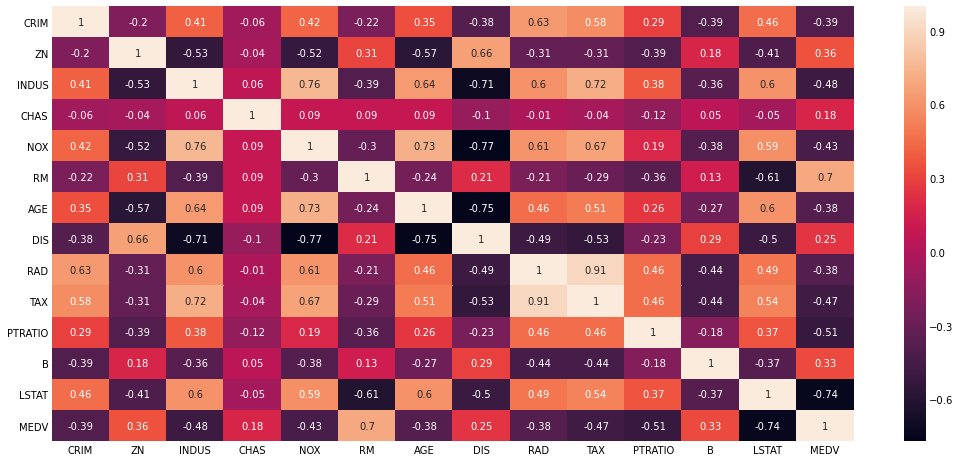

In [6]:
correlation_matrix = bostondf.corr().round(2)
plt.figure(figsize = (16,8))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [7]:
bostondf.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

## Imputation Study 

With the goal of assessing the impact of missingness and imputation on predictive models, we have designed a multi-step exercise with a baseline model on the complete data set and subsequent iterations with data **missing completely at random, missing at random, and missing not at random.** These represent the patterns we found in our larger problems. 

### Methodology

We begin with a baseline model using a simple linear regression to predict the median house value (MEDV), using the variables noted above. As we progress through the exercise, data is removed from the dataset in the following percentages: 1%, 5% 10%, 20%, 33%, and 50%. In each iteration, the removed data is from the same attribute, while using the same model and parameters that were used in the baseline. We determined which attribute data to remove by finding the attribute with the largest impact on the predicted variables in the model. Then, we replace the missing information using a basic imputation strategy, as outlined in each step of the exercise. Each time the model is fit to a different imputed data set for prediction, it will be compared with the baseline model using the four metrics below:  

* **Mean Absolute Error (MAE)** is a measure of errors between paired observations and the prediction. The error is always measured as distance from zero. 

* **Mean Squared Error (MSE)** of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

* **Root Mean Square Error (RMSE)** is the MSE except it is in the same unit measure as the data. This is much easier to interpret the impact in terms of the predicted unit. 

* **R-Squared** measure of fit that indicates how much variation of a dependent variable is explained by the independent variable(s) in a regression model

In [8]:
# Create training and testing sets (cross-validation not needed)
train_set = bostondf.sample(frac=0.7, random_state=100)
test_set = bostondf[~bostondf.isin(train_set)].dropna()
print(train_set.shape[0])
print(test_set.shape[0])

354
152


### For visualizations of the training set and test set, see Appendix: Training and Test Set Analysis

In [9]:
# Get the training and testing row indices for later use
train_index = train_set.index.values.astype(int)
test_index = test_set.index.values.astype(int)

In [10]:
# Demonstration of using the row indices above to select consistent records
bostondf.iloc[train_index].head()

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
198  0.03768  80.0   1.52   0.0  0.404  7.274   38.3  7.3090  2.0  329.0   
229  0.44178   0.0   6.20   0.0  0.504  6.552   21.4  3.3751  8.0  307.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120   76.7  2.2875  1.0  273.0   
31   1.35472   0.0   8.14   0.0  0.538  6.072  100.0  4.1750  4.0  307.0   
315  0.25356   0.0   9.90   0.0  0.544  5.705   77.7  3.9450  4.0  304.0   

     PTRATIO       B  LSTAT  MEDV  
198     12.6  392.20   6.62  34.6  
229     17.4  380.34   3.76  31.5  
502     21.0  396.90   9.08  20.6  
31      21.0  376.73  13.04  14.5  
315     18.4  396.42  11.50  16.2

In [11]:
# Converting the training and testing datasets back to matrix-formats
X_train = train_set.iloc[:, :-1].values # returns the data; excluding the target
Y_train = train_set.iloc[:, -1].values # returns the target-only
X_test = test_set.iloc[:, :-1].values # ""
Y_test = test_set.iloc[:, -1].values # ""

In [12]:
Y_train

array([34.6, 31.5, 20.6, 14.5, 16.2, 22.3, 22.8, 24.4, 19.8, 16.7, 23.2,
       15.1, 21. , 18.9, 48.5, 24.1, 22.5, 16.1, 30.3, 50. , 33.8, 10.4,
       20.4, 14.2, 10.5, 12.7, 24.5, 16.7, 20.1, 17.1, 18.4, 24.3, 50. ,
       23.8, 30.7, 33.4, 15. , 10.9, 19.1, 21. , 22.9, 22.4, 19. , 19.3,
       27. , 27.1, 19.1, 15.4, 19.1, 13.5, 20.9, 19.3, 20.5, 26.2, 12. ,
       19.7, 29.6, 34.9,  8.3, 21.2, 14.5, 27.5, 19.4, 32.7, 21.1, 28.1,
       17.4, 30.1, 21.4, 20.9, 10.9, 21.7,  8.8, 15.2, 26.6,  8.7, 24.7,
       38.7,  6.3, 22.6, 43.8, 50. , 14.5, 11.7, 12.5, 13.6, 21.5, 19.1,
        9.5, 17.2, 29.8, 22.6, 21.6, 22.2, 27.1, 17. , 22. , 50. ,  7.2,
       50. , 14. , 11. , 10.2, 22.1, 41.3, 17.6, 24.7,  8.5,  8.1, 26.4,
       23. , 35.1, 35.4, 12.8, 24. , 20.2, 29.4, 16. , 50. ,  8.5, 14.9,
       13.8, 21.8, 23.1, 20.1, 13.4, 15.3, 20. , 20. , 19.7, 22.8, 18.2,
       23.3, 18.4, 23. , 50. , 23.1, 23.3, 21.4, 21.4, 13.1,  7. , 14.3,
       31.2, 30.5, 19.6, 50. , 24.4, 18.8, 29.9, 12

### Baseline Model: Step 1
Fitting the Baseline model gives us two things: it gives us a model to compare against; and it illustrates the variables with the largest impacts (based on coefficients of the attributes). We see that NOX has the greatest impact to the predicted value, where an increase in nitric oxides (measured as parts per million) will decrease the median value of a home by approximately $20K. This is the variable that we will use to remove values and impute data. 


In [13]:
# Fit a linear regression to the training data
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.coef_)
print(reg.intercept_)
print(reg.get_params())

0.7478284701218886
[-1.35456753e-01  5.48606010e-02  5.46611167e-02  3.57648807e+00
 -2.01163242e+01  3.96567027e+00  1.33685712e-02 -1.48716658e+00
  2.99295349e-01 -9.83868843e-03 -9.45023886e-01  6.45207267e-03
 -5.77572297e-01]
36.079347688282304
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}


In [14]:
# Show Coeff of the variables 
for x,y in zip(bostondf.columns, reg.coef_):
    print(x," : ",y)

CRIM  :  -0.13545675283333689
ZN  :  0.05486060103359965
INDUS  :  0.05466111666902427
CHAS  :  3.576488065984514
NOX  :  -20.11632424763777
RM  :  3.9656702708586273
AGE  :  0.013368571236074277
DIS  :  -1.4871665788179078
RAD  :  0.29929534944621167
TAX  :  -0.009838688425542912
PTRATIO  :  -0.9450238858515401
B  :  0.0064520726706565655
LSTAT  :  -0.5775722969727087


In [15]:
# Find the variable with the largest "normalized" coefficient value
# print('The abs(max) coef-value is {}'.format(max(reg.coef_))) # Positive Max
print('The abs(max) coef-value is {}'.format(max(reg.coef_, key=abs))) # ABS Max
#max_var = max(reg.coef_) # Positive Max
max_var = max(reg.coef_, key=abs) # ABS Max
var_index = reg.coef_.tolist().index(max_var)
print('The variable associated with this coef-value is {}'.format(boston.feature_names[var_index]))

The abs(max) coef-value is -20.11632424763777
The variable associated with this coef-value is NOX


In [16]:
Y_pred = reg.predict(X_test)

orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%orig_mae)
print("MSE:  %.3f"%orig_mse)
print("RMSE:  %.3f"%orig_rmse_val)
print("R2:  %.3f"%orig_r2)

MAE: 3.605
MSE:  24.099
RMSE:  4.909
R2:  0.705


In [17]:
res_frame = pd.DataFrame({ 'Imputation %':0,
                           'imputation':'none',
                           'mae': orig_mae, 
                           'mse': orig_mse, 
                           'rmse':orig_rmse_val, 
                           'R2':orig_r2,
                           'mae_diff':np.nan,
                           'mse_diff':np.nan,
                           'rmse_diff':np.nan,
                           'R2_diff':np.nan
                                 }, index=[0])


**Model Summary** 

The scatter plot below shows the predicted median house value against the actual median house value. We wanted to do a quick visual check to see how our model performed. The black line represents a perfect prediction.  There is a good distribution above and below the line, so we feel it is a good baseline to use. We do note, towards the top end of prices, there seems to be some bias where the model does predict lower than the actuals. If this exercise was about getting the highest accuracy instead of measuring the impact of imputation, it would warrant a look into this bias and further tuning the model. 

Text(0.5, 1.0, 'Actual Prices vs Predicted prices')

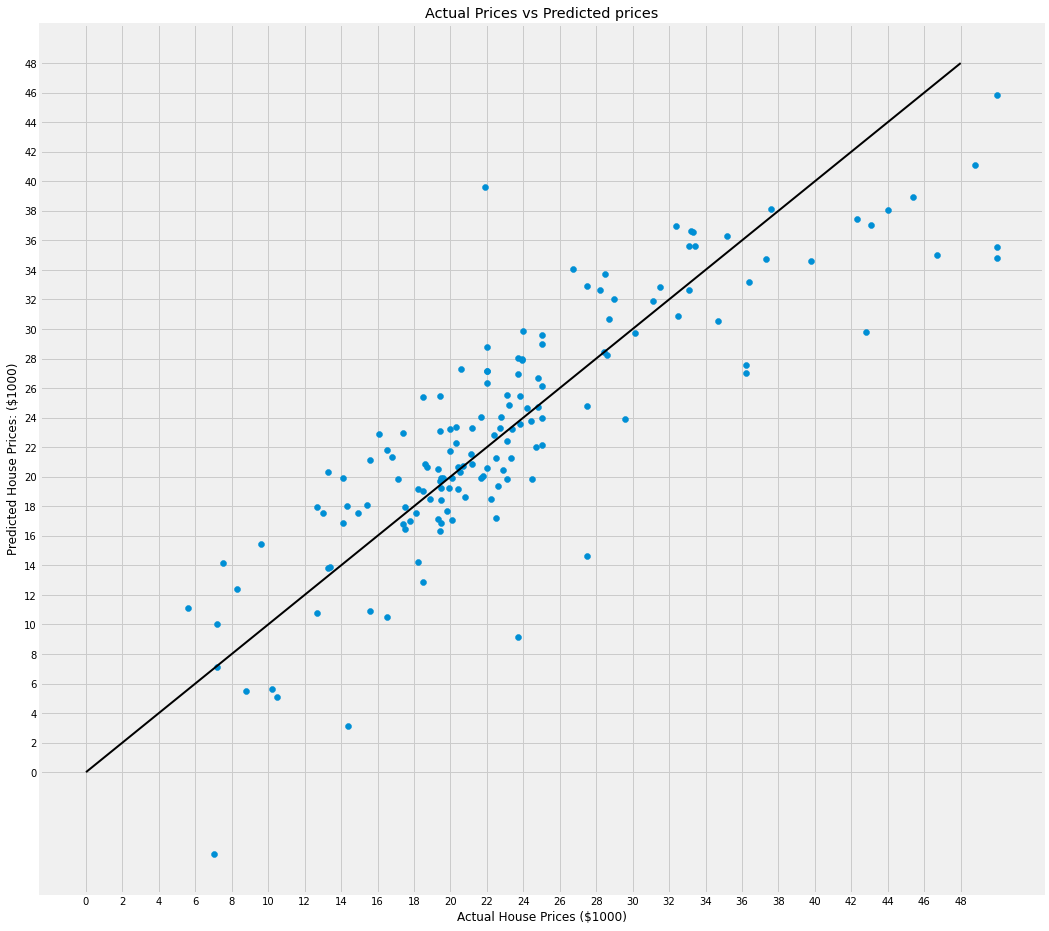

In [18]:
plt.figure(figsize = (16,16))
plt.scatter(Y_test, Y_pred)
plt.plot([0, 48], [0, 48], color = 'black', linewidth = 2)
plt.xlabel("Actual House Prices ($1000)")
plt.ylabel("Predicted House Prices: ($1000)")
plt.xticks(range(0, int(max(Y_test)),2))
plt.yticks(range(0, int(max(Y_test)),2))

plt.title("Actual Prices vs Predicted prices")

### Imputation Analysis: Step 2 - Missing Completely at Random (MCAR)

The below function removes the specified percentages (1%, 5% 10%, 20%, 33%, and 50%) at random of NOX from the dataset. Data **missing completely at random (MCAR)** is defined where the probablity of missing values in a variable is the same for all samples.  

For our **imputation strategy**, we elected to use the median value as it is a good centralized statistic and not subjected to outlier impact in the same way the mean could be. We then fit the same model as the baseline on the newly imputed data to obtain the four metrics discussed above. The results are stored for comparison and later discussion.


In [19]:
def imputation_defintion(frac):
    # Here we randomly sample the full dataset and replace a single column's values  
    in_sample = bostondf.sample(frac=frac, random_state=99)
    in_sample.shape
    out_sample = bostondf[~bostondf.isin(in_sample)].dropna()
    out_sample.shape

    print(out_sample.shape[0] + in_sample.shape[0])
    print(bostondf.shape[0])

    in_sample.head()

    ## Choose a variable to replace   
    in_sample['NOX'] = np.nan
    #in_sample['RM'] = np.nan
    in_sample.head()

    out_sample['NOX'].median()
    #out_sample['RM'].median()

    #in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    #in_sample['NOX'] = in_sample['NOX'].fillna(1)
 
    #**Choose an imputation method**   
    in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
        #in_sample['RM'] = in_sample['RM'].fillna(out_sample['RM'].median())
    in_sample.head()
    #**Rejoin the imputed and original datasets**
    imputed_data = pd.concat([in_sample, out_sample])
    imputed_data = imputed_data.sort_index()
    imputed_data.head()

    #**Use the same training and testing indices to fit the model**    
    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]
    train_set.head()
    
    X_train = train_set.iloc[:, :-1].values
    Y_train = train_set.iloc[:, -1].values
    X_test = test_set.iloc[:, :-1].values
    Y_test = test_set.iloc[:, -1].values

    #**Fit a new model to the imputed dataset**
    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)
    plt.figure(figsize = (16,8))
    plt.title(frac)
    plt.suptitle("Actual Prices vs Predicted prices")
    sns.distplot((Y_test-Y_pred),bins=50);
    
    temp_frame = pd.DataFrame({'Imputation %':frac,
                   'imputation':'MCAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])
    return temp_frame, Y_test-Y_pred

#### Subsequent rounds of imputation for MCAR

506
506
0.7473400313643322
[-1.35155795e-01  5.52707124e-02  5.04512207e-02  3.57426168e+00
 -1.95531963e+01  3.97717969e+00  1.16279357e-02 -1.49119813e+00
  2.97443527e-01 -9.82195776e-03 -9.38304171e-01  6.47444250e-03
 -5.78432444e-01]
35.77832591834361
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.612
MSE:  24.082
RMSE:  4.907
R2:  0.705
506
506
0.7476551630095785
[-1.31860849e-01  5.40504320e-02  4.60203744e-02  3.38658644e+00
 -1.88916248e+01  4.07601298e+00  1.06991810e-02 -1.46423483e+00
  2.89255172e-01 -1.00158356e-02 -9.16770518e-01  5.76864996e-03
 -5.84158646e-01]
34.857419839734106
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.659
MSE:  24.641
RMSE:  4.964
R2:  0.698
506
506
0.7437202924848851
[-1.27056590e-01  5.51392493e-02  2.91485534e-02  3.53112136e+00
 -1.56113087e+01  4.08910005e+00  7.38118179e-03 -1.41736201e+00
  2.72886172e-01 -9.99168622e-03 -8.68825044e-01  6.40288169e-03
 -5.88525597e

Imputation % imputation       mae        mse      rmse        R2  mae_diff  \
0          0.00       none  3.604571  24.098505  4.909023  0.704940       NaN   
0          0.01       MCAR  3.611796  24.081772  4.907318  0.705145  0.007225   
0          0.05       MCAR  3.658619  24.641265  4.963997  0.698294  0.054048   
0          0.10       MCAR  3.657249  24.979995  4.997999  0.694147  0.052677   
0          0.20       MCAR  3.557174  24.042646  4.903330  0.705624 -0.047397   
0          0.33       MCAR  3.564066  24.041875  4.903251  0.705633 -0.040505   
0          0.50       MCAR  3.619510  24.446555  4.944346  0.700678  0.014939   

   mse_diff  rmse_diff   R2_diff  
0       NaN        NaN       NaN  
0 -0.016733  -0.001705  0.000205  
0  0.542761   0.054974 -0.006646  
0  0.881490   0.088976 -0.010793  
0 -0.055858  -0.005693  0.000684  
0 -0.056630  -0.005771  0.000693  
0  0.348050   0.035323 -0.004261

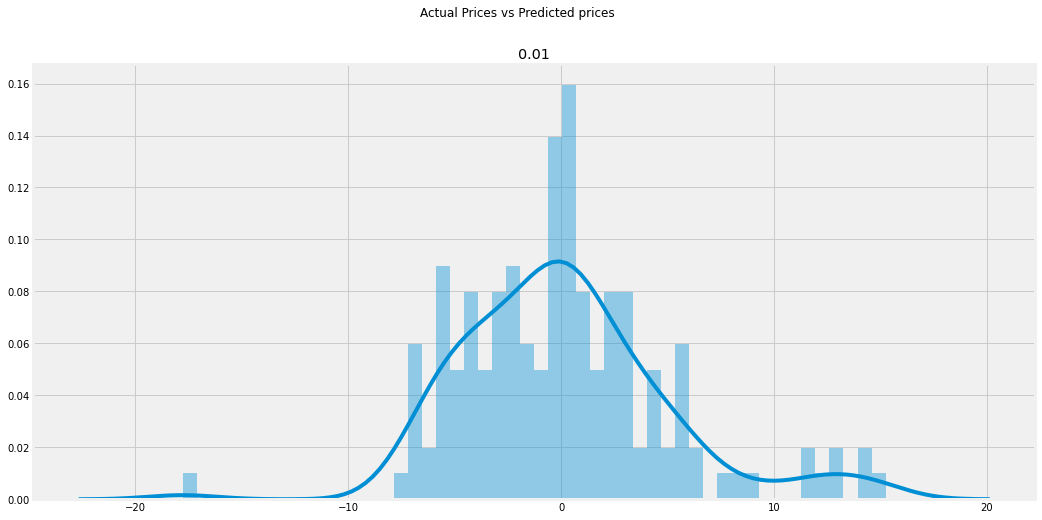

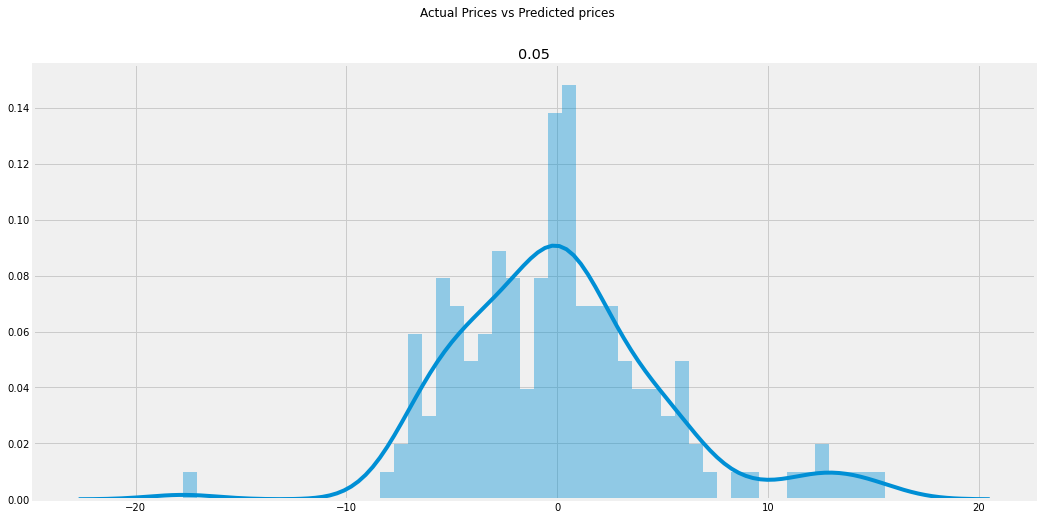

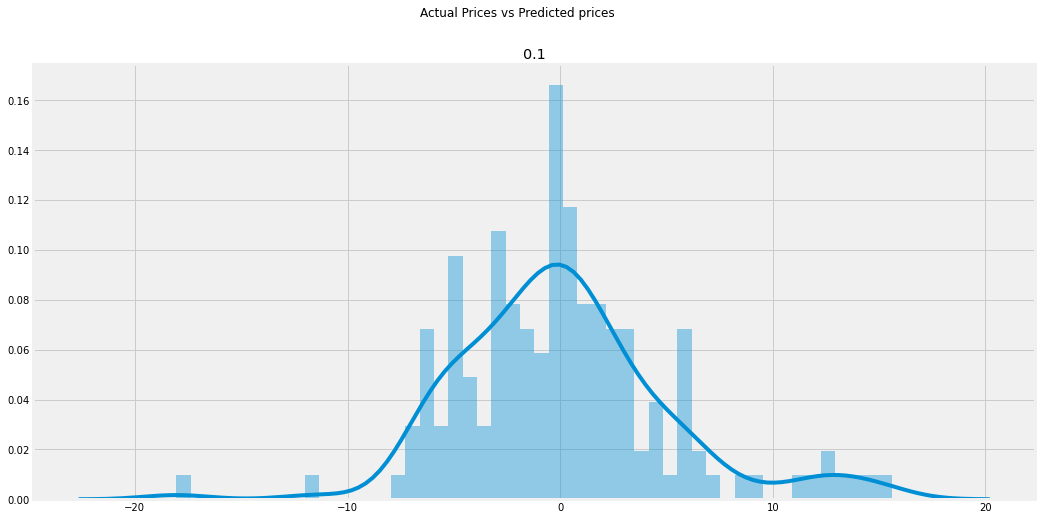

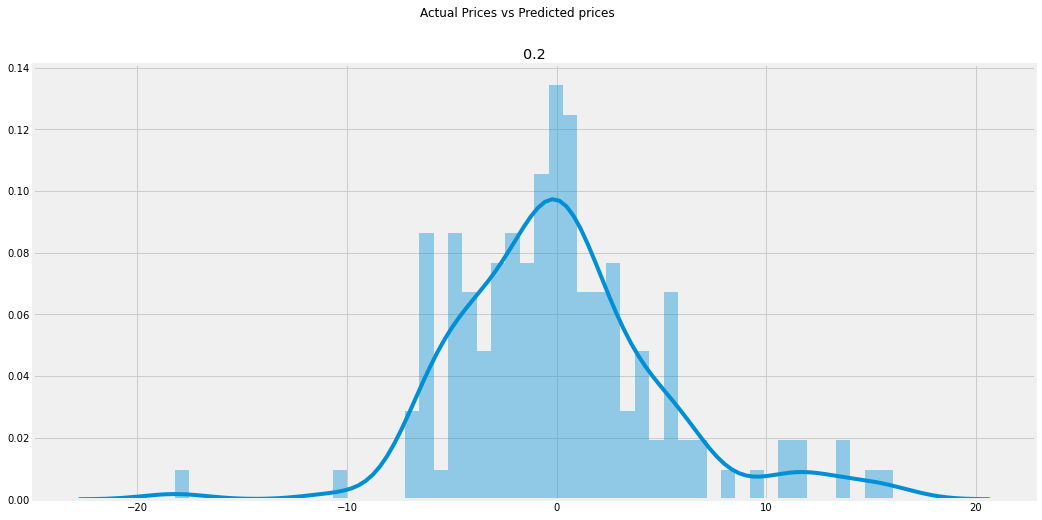

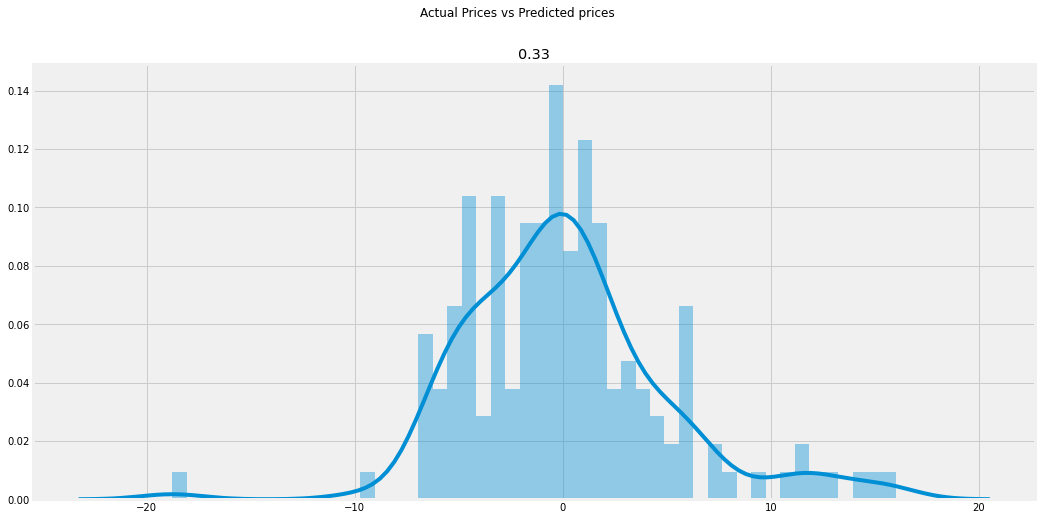

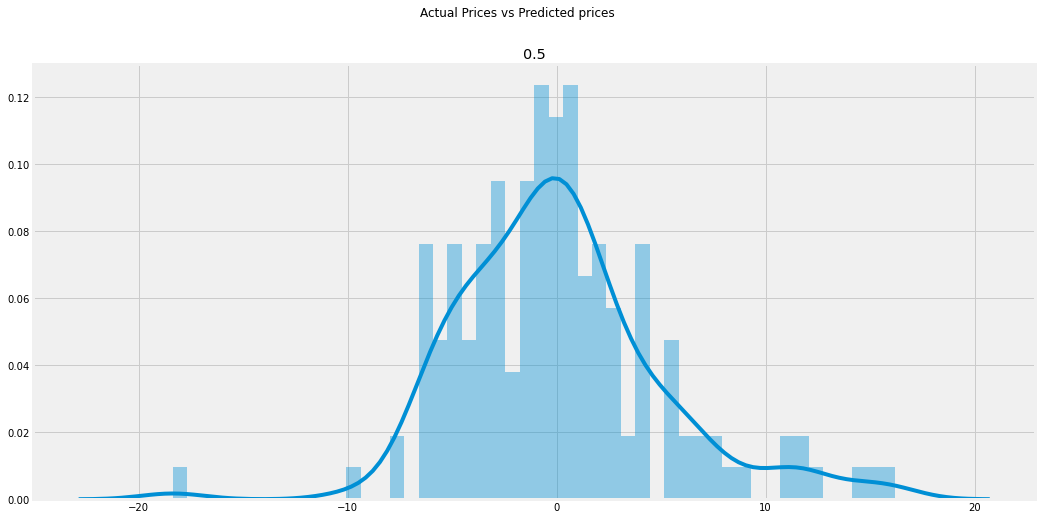

In [20]:
#1%, 5% 10%, 20%, 33%, and 50% 
temp_frame = imputation_defintion(.01)
res_frame = pd.concat([res_frame, temp_frame[0]])
temp_frame
res01 = temp_frame[1]
temp_frame = imputation_defintion(.05)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res05 = temp_frame[1]
temp_frame = imputation_defintion(.1)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res10 = temp_frame[1]
temp_frame = imputation_defintion(.2)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res20 = temp_frame[1]
temp_frame = imputation_defintion(.33)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res33 = temp_frame[1]
temp_frame = imputation_defintion(.5)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res50 = temp_frame[1]
res_frame

In [21]:
res_frame

Imputation % imputation       mae        mse      rmse        R2  mae_diff  \
0          0.00       none  3.604571  24.098505  4.909023  0.704940       NaN   
0          0.01       MCAR  3.611796  24.081772  4.907318  0.705145  0.007225   
0          0.05       MCAR  3.658619  24.641265  4.963997  0.698294  0.054048   
0          0.10       MCAR  3.657249  24.979995  4.997999  0.694147  0.052677   
0          0.20       MCAR  3.557174  24.042646  4.903330  0.705624 -0.047397   
0          0.33       MCAR  3.564066  24.041875  4.903251  0.705633 -0.040505   
0          0.50       MCAR  3.619510  24.446555  4.944346  0.700678  0.014939   

   mse_diff  rmse_diff   R2_diff  
0       NaN        NaN       NaN  
0 -0.016733  -0.001705  0.000205  
0  0.542761   0.054974 -0.006646  
0  0.881490   0.088976 -0.010793  
0 -0.055858  -0.005693  0.000684  
0 -0.056630  -0.005771  0.000693  
0  0.348050   0.035323 -0.004261

### Imputation Analysis: Step 3 - Missing at Random (MAR)
In the next step of the experiment, we measure the performance of the model when the data is missing at random (not *completely* at random as was the case above). **Missing at random (MAR)** is defined as the probability of missing values, at random, in a varible depend only on the available information in other predictors. MAR can be handled by using information in other predictors to impute missing information. 

For this, we elected to use the variable **age** to obtain a subset of data and remove some of the values. The age of 77 was used a threshold; this is the median value of the age observations. Those greater than 77 will be removed and again imputed with the median. We will then see what impact this imputation has on the model's performance.  


In [22]:
bostondf.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [23]:
bostondfa = bostondf[bostondf['AGE'] > 77.5]
bostondfb = bostondf[bostondf['AGE'] <= 77.5]
bostondfa.head()

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
1   0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671  2.0  242.0   
7   0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505  5.0  311.0   
8   0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821  5.0  311.0   
9   0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921  5.0  311.0   
10  0.22489  12.5   7.87   0.0  0.524  6.377   94.3  6.3467  5.0  311.0   

    PTRATIO       B  LSTAT  MEDV  
1      17.8  396.90   9.14  21.6  
7      15.2  396.90  19.15  27.1  
8      15.2  386.63  29.93  16.5  
9      15.2  386.71  17.10  18.9  
10     15.2  392.52  20.45  15.0

In [24]:
def imputation_defintion_two_variables(frac):
    
#	CRIM	ZN	INDUS	CHAS	NOX	RM	AGE	DIS	RAD	TAX	PTRATIO	B	LSTAT	MEDV
#0	0.00632	18.0	2.31	0.0	0.538	6.575	65.2	4.0900	1.0	296.0	15.3	396.90	4.98	24.0
#1	0.02731	0.0	7.07	0.0	0.469	6.421	78.9	4.9671	2.0	242.0	17.8	396.90	9.14	21.6
#2	0.02729	0.0	7.07	0.0	0.469	7.185	61.1	4.9671	2.0	242.0	17.8	392.83	4.03	34.7
#3	0.03237	0.0	2.18	0.0	0.458	6.998	45.8	6.0622	3.0	222.0	18.7	394.63	2.94	33.4
#4	0.06905	0.0	2.18	0.0	0.458	7.147	54.2	6.0622	3.0	222.0	18.7	396.90	5.33	36.2    
#    :Attribute Information (in order):
#        - CRIM     per capita crime rate by town
#        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#        - INDUS    proportion of non-retail business acres per town
#        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#        - NOX      nitric oxides concentration (parts per 10 million)
#        - RM       average number of rooms per dwelling
#        - AGE      proportion of owner-occupied units built prior to 1940
#        - DIS      weighted distances to five Boston employment centres
#        - RAD      index of accessibility to radial highways
#        - TAX      full-value property-tax rate per $10,000
#        - PTRATIO  pupil-teacher ratio by town
#        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#        - LSTAT    % lower status of the population
#        - MEDV     Median value of owner-occupied homes in $1000's

#get two dataframes one with age over 77.5 one with less.
    bostondfa = bostondf[bostondf['AGE'] > 77.5]
    bostondfb = bostondf[bostondf['AGE'] <= 77.5]


#**Here we can randomly sample the over 77.5 dataset and replace a single column's values**  
    in_sample = bostondfa.sample(frac=frac, random_state=99)
    in_sample.shape
    out_sample = bostondfa[~bostondfa.isin(in_sample)].dropna()
    out_sample.shape

    print(out_sample.shape[0] + in_sample.shape[0])
    print(bostondf.shape[0])

    in_sample.head()

 ## Choose variables to replace   
    #in_sample['NOX'] = np.nan
    in_sample['RM'] = np.nan
    in_sample['INDUS'] = np.nan
    in_sample.head()

    #out_sample['NOX'].median()
    out_sample['RM'].median()
    out_sample['INDUS'].median()

    #in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    #in_sample['NOX'] = in_sample['NOX'].fillna(1)
 #**Choose an imputation method**   
    in_sample['RM'] = in_sample['RM'].fillna(out_sample['RM'].median())
    in_sample['INDUS'] = in_sample['INDUS'].fillna(out_sample['INDUS'].median())
    in_sample.head()
#**Rejoin the imputed and original datasets**
    frames = [in_sample, out_sample, bostondfb]
    imputed_data = pd.concat(frames)
    imputed_data = imputed_data.sort_index()
    imputed_data.head()

#**Use the same training and testing indices to fit the model**    
    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]
    train_set.head()
    
    X_train = train_set.iloc[:, :-1].values
    Y_train = train_set.iloc[:, -1].values
    X_test = test_set.iloc[:, :-1].values
    Y_test = test_set.iloc[:, -1].values

#**Fit a new model to the imputed dataset**
    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)
    plt.figure(figsize = (16,8))
    plt.title(frac)
    plt.suptitle("Actual Prices vs Predicted prices")
    sns.distplot((Y_test-Y_pred),bins=50);
    
    temp_frame = pd.DataFrame({'Imputation %':frac,
                   'imputation':'MAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])
    return temp_frame, Y_test-Y_pred

253
506
0.7507240573328869
[-1.32417022e-01  5.23899558e-02  2.57703675e-02  3.49910039e+00
 -1.91777985e+01  4.07589307e+00  1.52278394e-02 -1.49481944e+00
  2.91605651e-01 -9.50004366e-03 -9.56156925e-01  6.35203636e-03
 -5.83636136e-01]
35.380485525751034
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.579
MSE:  23.929
RMSE:  4.892
R2:  0.707


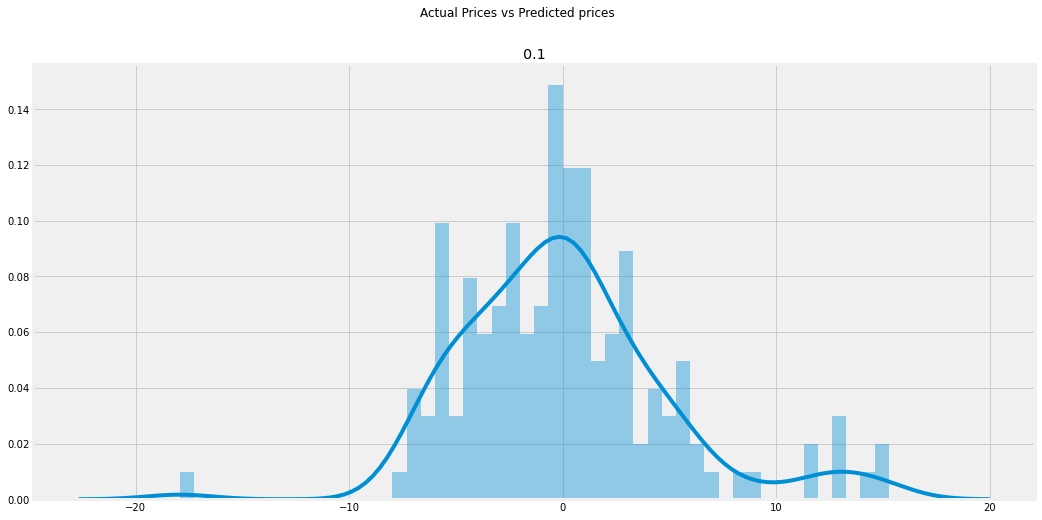

In [25]:
#10%, 20%, 30%
temp_frame2 = imputation_defintion_two_variables(.1)
temp_frame2
res_frame2 =temp_frame2[0]
#res_frame2
res210 = temp_frame[1]

253
506
0.7453145516995417
[-1.32842145e-01  5.34954113e-02  1.55581248e-02  3.57849676e+00
 -1.99229250e+01  3.81584780e+00  1.81989587e-02 -1.52934268e+00
  2.99103763e-01 -9.50688639e-03 -9.54804537e-01  6.00593413e-03
 -6.10887064e-01]
37.801680748379184
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.551
MSE:  23.620
RMSE:  4.860
R2:  0.711
253
506
0.7396696681696734
[-1.33527752e-01  5.49163040e-02  3.87108178e-02  3.84887613e+00
 -2.01661966e+01  3.63983437e+00  2.03874495e-02 -1.52780556e+00
  3.17996013e-01 -1.03823502e-02 -9.89256666e-01  5.74078137e-03
 -6.41861912e-01]
39.915372132668764
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.542
MSE:  22.701
RMSE:  4.765
R2:  0.722


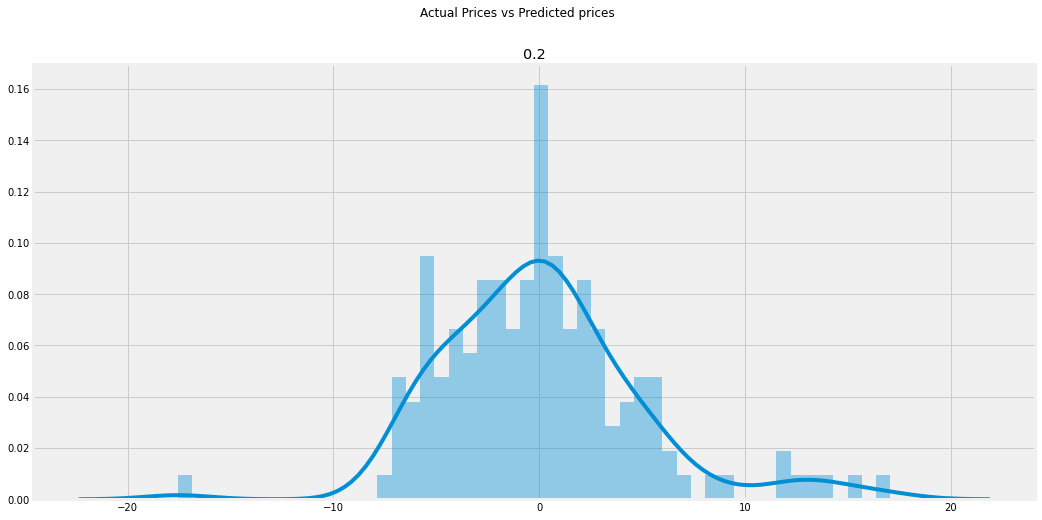

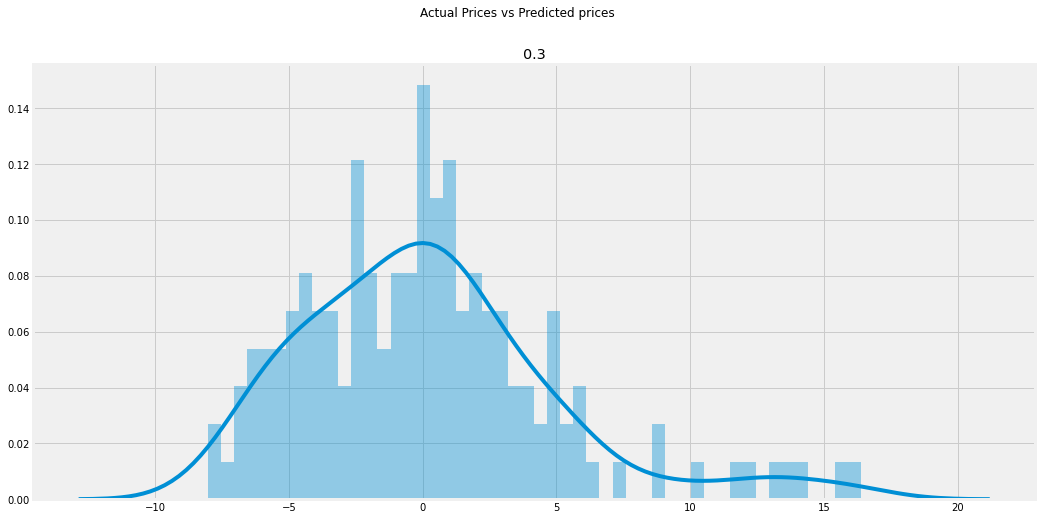

In [26]:
temp_frame2 = imputation_defintion_two_variables(.2)
temp_frame2
res_frame2 = pd.concat([res_frame2, temp_frame2[0]])
res220 = temp_frame[1]

temp_frame2 = imputation_defintion_two_variables(.3)
temp_frame2
res_frame2 = pd.concat([res_frame2, temp_frame2[0]])
res230 = temp_frame[1]

In [27]:
res_frame2
res_frame = pd.concat([res_frame, res_frame2])

In [28]:
res_frame

Imputation % imputation       mae        mse      rmse        R2  mae_diff  \
0          0.00       none  3.604571  24.098505  4.909023  0.704940       NaN   
0          0.01       MCAR  3.611796  24.081772  4.907318  0.705145  0.007225   
0          0.05       MCAR  3.658619  24.641265  4.963997  0.698294  0.054048   
0          0.10       MCAR  3.657249  24.979995  4.997999  0.694147  0.052677   
0          0.20       MCAR  3.557174  24.042646  4.903330  0.705624 -0.047397   
0          0.33       MCAR  3.564066  24.041875  4.903251  0.705633 -0.040505   
0          0.50       MCAR  3.619510  24.446555  4.944346  0.700678  0.014939   
0          0.10        MAR  3.578703  23.929496  4.891778  0.707009 -0.025868   
0          0.20        MAR  3.551250  23.620080  4.860049  0.710798 -0.053322   
0          0.30        MAR  3.541983  22.701046  4.764562  0.722050 -0.062588   

   mse_diff  rmse_diff   R2_diff  
0       NaN        NaN       NaN  
0 -0.016733  -0.001705  0.000205  
0  0.542761   0.054974 -0.006646  
0  0.881490   0.088976 -0.010793  
0 -0.055858  -0.005693  0.000684  
0 -0.056630  -0.005771  0.000693  
0  0.348050   0.035323 -0.004261  
0 -0.169009  -0.017244  0.002069  
0 -0.478425  -0.048973  0.005858  
0 -1.397458  -0.144461  0.017110

### Imputation Analysis: Step 4 - Missing Not at Random (MNAR)

The final step of the exercise is to impute missing data that is **missing not at random (MNAR)**. We again use the NOX variable as missing. In reality, this could be a siutation where a sensor may have gone bad and stopped recording air quality. We simulate an example where the last 25% of NOX data is missing due to collection failure.

In [29]:
def imputation_defintion_nar(frac):
#**Here we can randomly sample the full dataset and replace a single column's values**  
    numrows = len(bostondf)
    numrows
    twentyfivepercent = round(numrows * frac)
    twentyfivepercent
    in_sample = bostondfb.iloc[twentyfivepercent:]
    in_sample.shape
    out_sample = bostondf[~bostondf.isin(in_sample)].dropna()
    out_sample.shape

    print(out_sample.shape[0] + in_sample.shape[0])
    print(bostondf.shape[0])

    in_sample.head()

 ## Choose a variable to replace   
    in_sample['NOX'] = np.nan
    #in_sample['RM'] = np.nan
    in_sample.head()

    out_sample['NOX'].median()
    #out_sample['RM'].median()

    #in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    #in_sample['NOX'] = in_sample['NOX'].fillna(1)
 #**Choose an imputation method**   
    #in_sample['RM'] = in_sample['RM'].fillna(out_sample['RM'].median())
    in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    in_sample.head()
#**Rejoin the imputed and original datasets**
    imputed_data = pd.concat([in_sample, out_sample])
    imputed_data = imputed_data.sort_index()
    imputed_data.head()

#**Use the same training and testing indices to fit the model**    
    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]
    train_set.head()
    
    X_train = train_set.iloc[:, :-1].values
    Y_train = train_set.iloc[:, -1].values
    X_test = test_set.iloc[:, :-1].values
    Y_test = test_set.iloc[:, -1].values

#**Fit a new model to the imputed dataset**
    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)

    plt.figure(figsize = (16,8))
    plt.title(frac)
    plt.suptitle("Actual Prices vs Predicted prices")
    sns.distplot((Y_test-Y_pred),bins=50);
    
    temp_frame = pd.DataFrame({'Imputation %':frac,
                   'imputation':'MNAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])
    return temp_frame, Y_test-Y_pred

In [30]:
numrows = len(bostondf)
numrows
twentyfivepercent = round(numrows * .25)
twentyfivepercent

126

506
506
0.7464238757815276
[-1.26118957e-01  5.67664057e-02  5.21905891e-02  3.66929679e+00
 -1.65432173e+01  3.93903584e+00  9.88054774e-03 -1.21482275e+00
  2.87958847e-01 -9.97283815e-03 -9.28021921e-01  6.78056752e-03
 -5.86552817e-01]
33.51409706596738
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.548
MSE:  24.029
RMSE:  4.902
R2:  0.706


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


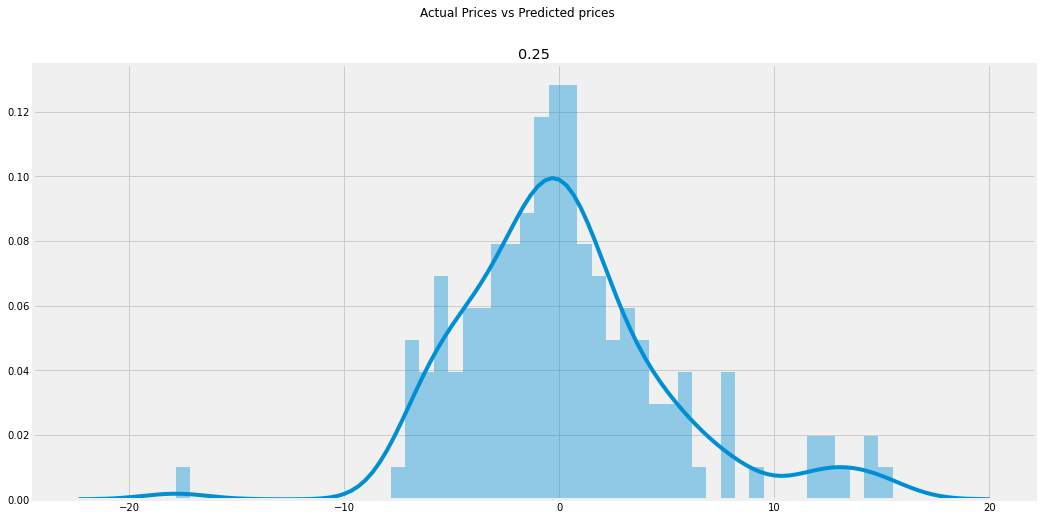

In [31]:
temp_frame3 = imputation_defintion_nar(.25)
temp_frame3
resnar = temp_frame3[1]

## Conclusion

We identified above that NOX has the greatest impact to the predicted value with a -20.1K in median home value for every increase in nitric oxides parts per 10million. We therefore decided to use this variable to test our imputation approach with varying degrees of missing data. 

Using different missing data approaches - MCAR, MAR (2 variables) & MNAR with varying percentages of missing data ranging from 1% to 50% we replaced the baseline data variable with the "median" of the missing variable (NOX).

Leveraging density plots and error scores for MAE, MSE, RMSE and R2 to compare and contrast the results between the baseline and imputed models we can summarize the following:

#### Density Plot
![title](img/DensityPlot_Combined.png) 

In reviewing the combined Density plot above, that as the peaks get taller suggesting that the shoulders move in toward the mean in accordance with the Central Limit Theorem.  The theorem states that in a population with mean μ and standard deviation σ if sufficiently large random samples are taken from the population with replacement , then the distribution of the sample means will be approximately normally distributed.


#### Error Metrics
![title](img/MARvsMAR2V_Errors2.png) 
**Error Metrics:** In comparing the error scores by imputed model, it is evident that the error keeps reducing wiht the increase in imputation while the R2 (Good of fit) increases.  This is expectedc as we are imputing missing data with the median or mean thereby reducing the variability and imporving R2 while reducing MAE, MSE and RMSE.



In [34]:

plt.figure(figsize = (16,8))
plt.suptitle("Actual Prices vs Predicted prices")
sns.distplot((res0),bins=50, hist=False, rug=True, label= "Baseline");
sns.distplot((res01),bins=50, hist=False, rug=True, label= "Completely at Random 1%"); 
sns.distplot((res05),bins=50, hist=False, rug=True, label= "Completely at Random 5%"); 
sns.distplot((res10),bins=50, hist=False, rug=True, label= "Completely at Random 10%");
sns.distplot((res20),bins=50, hist=False, rug=True, label= "Completely at Random 20%"); 
sns.distplot((res33),bins=50, hist=False, rug=True, label= "Completely at Random 33%"); 
sns.distplot((res50),bins=50, hist=False, rug=True, label= "Completely at Random 50%"); 
sns.distplot((res210),bins=50, hist=False, rug=True, label= "At Random 10%");
sns.distplot((res220),bins=50, hist=False, rug=True, label= "At Random 20%");
sns.distplot((res230),bins=50, hist=False, rug=True, label= "At Random 30%");
sns.distplot((resnar),bins=50, hist=False, rug=True, label= "Not at Random");
plt.show()

NameError: name 'res0' is not defined

<Figure size 1152x576 with 0 Axes>

In [35]:
res_frame = pd.concat([res_frame, temp_frame3[0]])
res_frame 
# res_frame.to_csv('CombinedMetrics.csv')


Imputation % imputation       mae        mse      rmse        R2  mae_diff  \
0          0.00       none  3.604571  24.098505  4.909023  0.704940       NaN   
0          0.01       MCAR  3.611796  24.081772  4.907318  0.705145  0.007225   
0          0.05       MCAR  3.658619  24.641265  4.963997  0.698294  0.054048   
0          0.10       MCAR  3.657249  24.979995  4.997999  0.694147  0.052677   
0          0.20       MCAR  3.557174  24.042646  4.903330  0.705624 -0.047397   
0          0.33       MCAR  3.564066  24.041875  4.903251  0.705633 -0.040505   
0          0.50       MCAR  3.619510  24.446555  4.944346  0.700678  0.014939   
0          0.10        MAR  3.578703  23.929496  4.891778  0.707009 -0.025868   
0          0.20        MAR  3.551250  23.620080  4.860049  0.710798 -0.053322   
0          0.30        MAR  3.541983  22.701046  4.764562  0.722050 -0.062588   
0          0.25       MNAR  3.547626  24.028774  4.901915  0.705794 -0.056945   
0          0.25       MNAR  3.547626  24.028774  4.901915  0.705794 -0.056945   

   mse_diff  rmse_diff   R2_diff  
0       NaN        NaN       NaN  
0 -0.016733  -0.001705  0.000205  
0  0.542761   0.054974 -0.006646  
0  0.881490   0.088976 -0.010793  
0 -0.055858  -0.005693  0.000684  
0 -0.056630  -0.005771  0.000693  
0  0.348050   0.035323 -0.004261  
0 -0.169009  -0.017244  0.002069  
0 -0.478425  -0.048973  0.005858  
0 -1.397458  -0.144461  0.017110  
0 -0.069730  -0.007107  0.000854  
0 -0.069730  -0.007107  0.000854

## References

- https://medium.com/towards-artificial-intelligence/handling-missing-data-for-advanced-machine-learning-b6eb89050357

- https://towardsdatascience.com/things-you-didnt-know-about-the-boston-housing-dataset-2e87a6f960e8

- https://www.kellogg.northwestern.edu/faculty/weber/jhu/statistics/boston.htm



## Appendix: Exploratory Data Analysis

**Data Overview**

In [36]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

**Pandas Profile Summary**

In [37]:
#!python -m pip install --upgrade pandas-profiling
from pandas_profiling import ProfileReport
# bostondf = pd.DataFrame(boston.data)
# dfboston.columns = boston.feature_names

profile = ProfileReport(bostondf, plot={'histogram': {'bins': 8}}, explorative=True)
profile.to_notebook_iframe()
profile.to_file("BostonHousing_Baseline_EDA_Report.html")

TypeError: _plot_histogram() got an unexpected keyword argument 'plot'

**Pair Plots and Box Plots**

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:513: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
C:\Anaconda3\lib\site-packages\matplotlib\contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Anaconda3\lib\site-packages\matplotlib\contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Anaconda3\lib\site-packages\matplotlib\contour.py:1132: RuntimeWarning: invalid value encountered in less
  un

Text(0.5, 1.0, 'Pair Plots for Boston Housing')

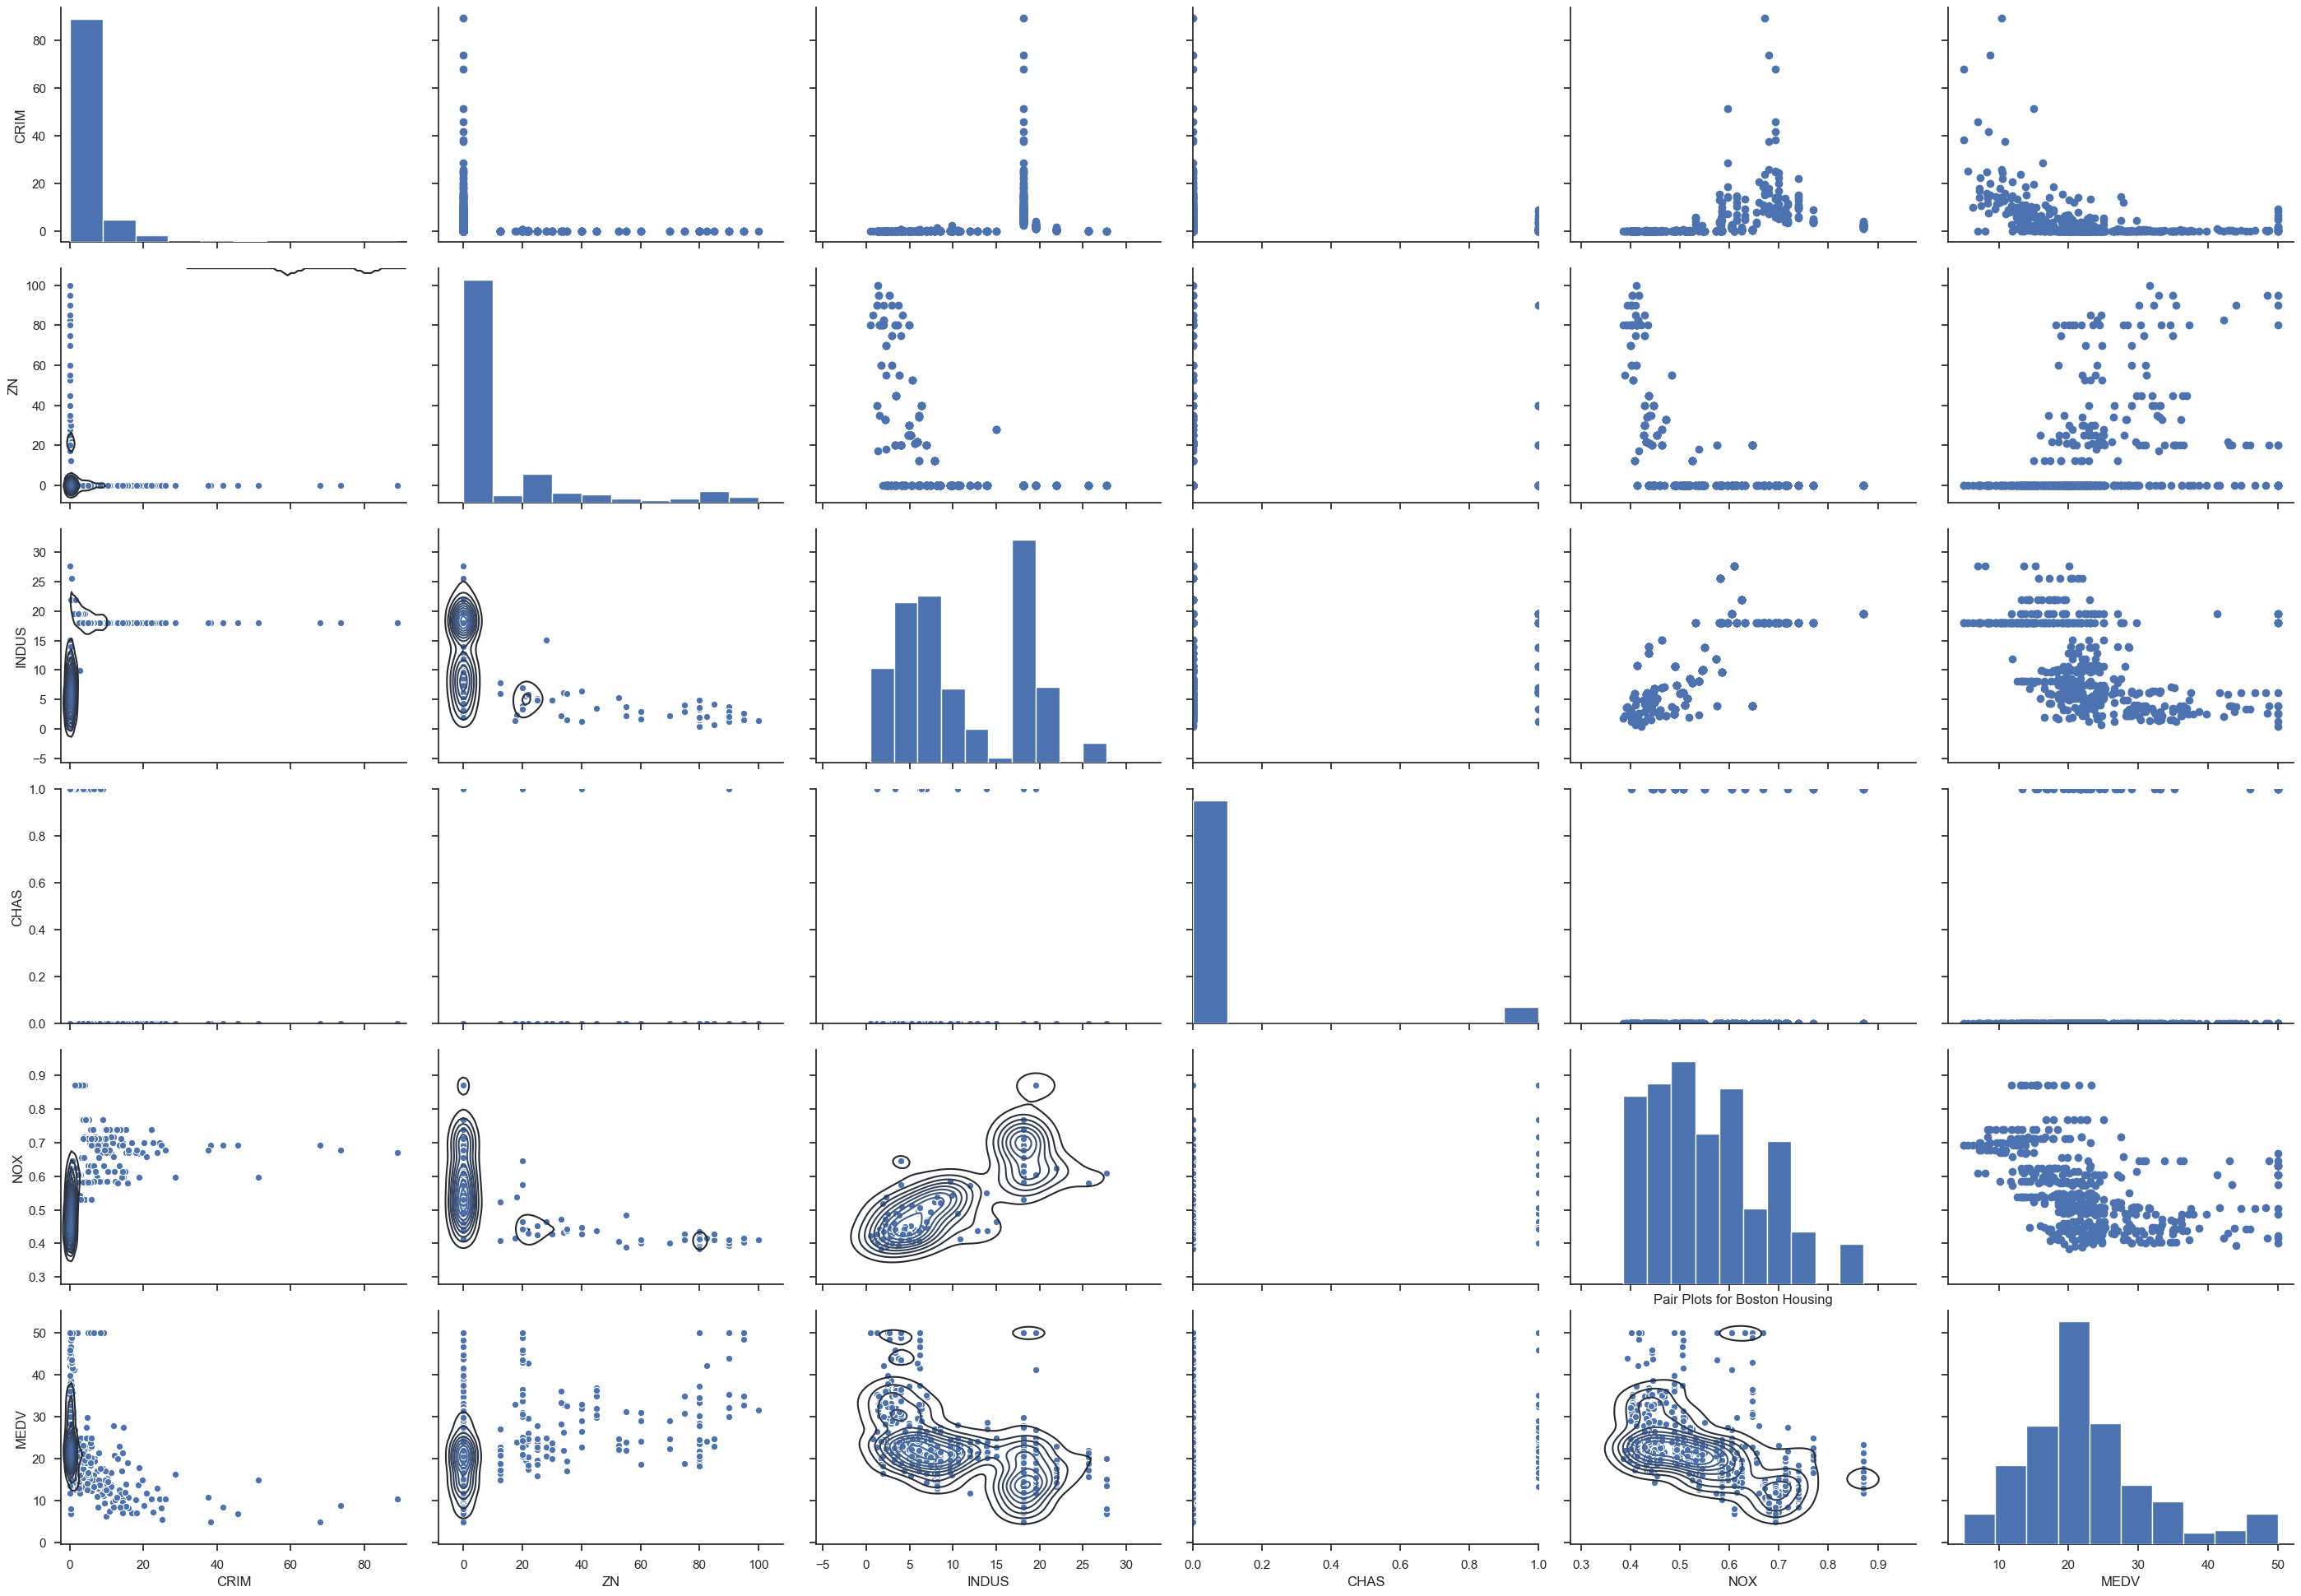

In [38]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(bostondf, vars=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',  'MEDV'], height=3.27, aspect=4.7/3.27)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
#iris = sns.load_dataset("iris")8.7/8.27)
plt.title("Pair Plots for Boston Housing")

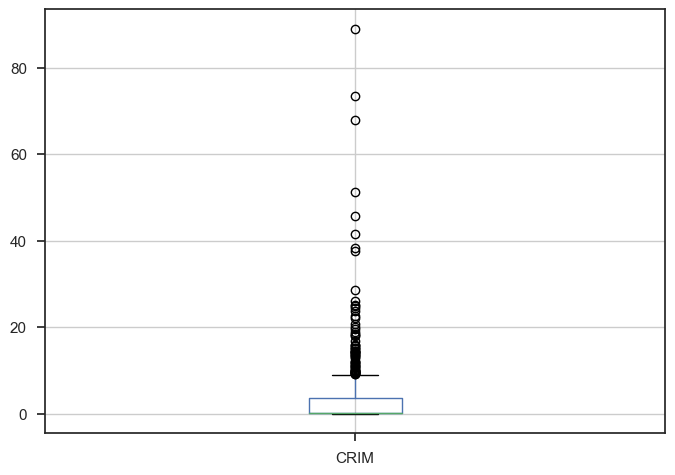

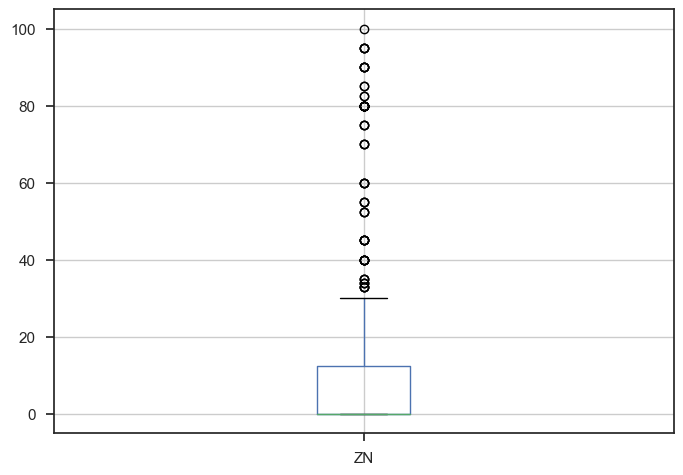

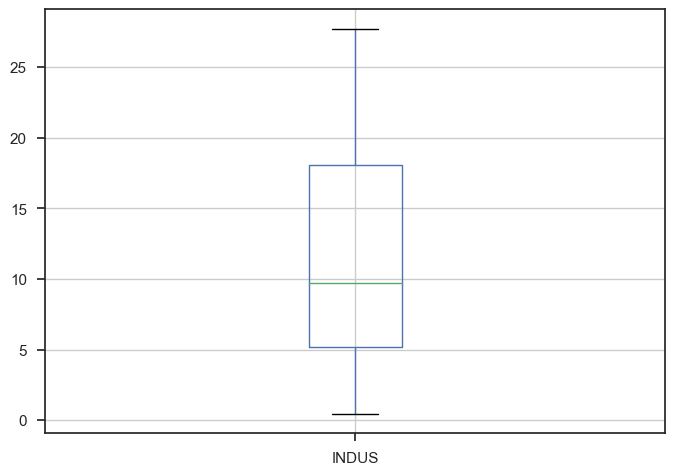

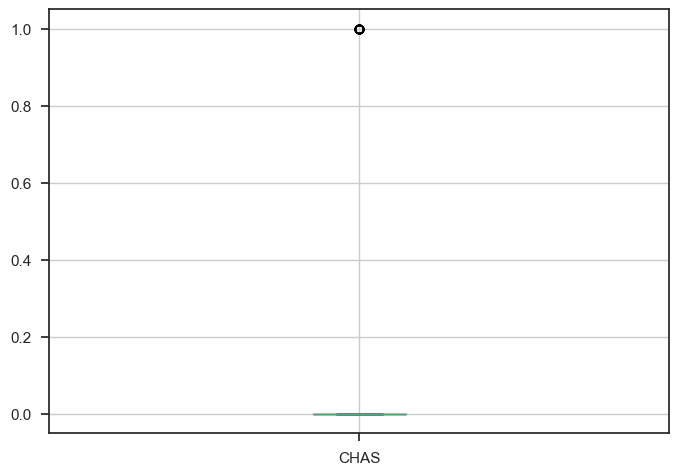

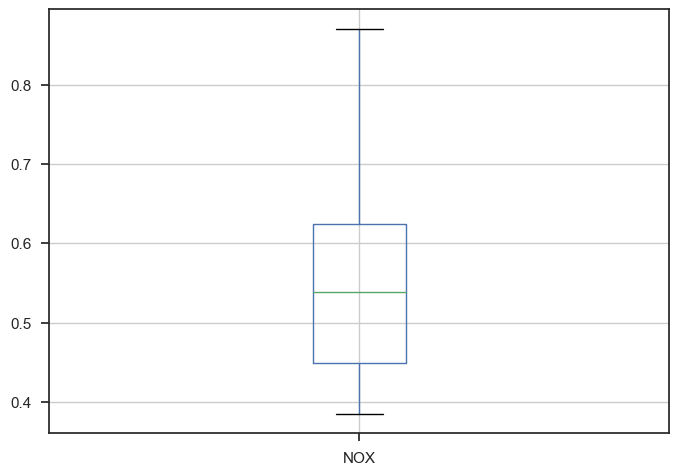

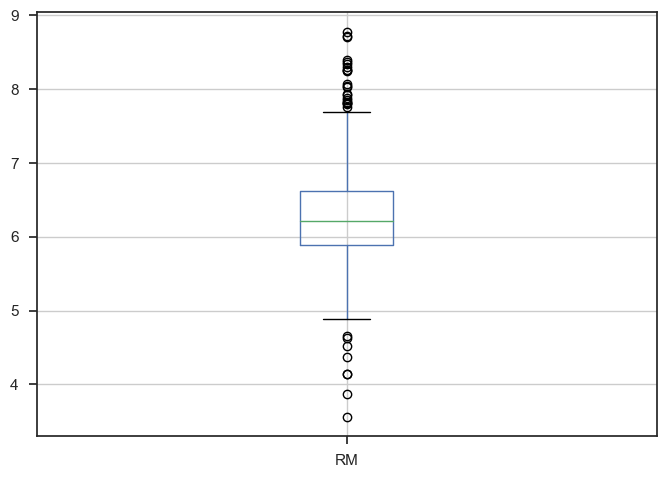

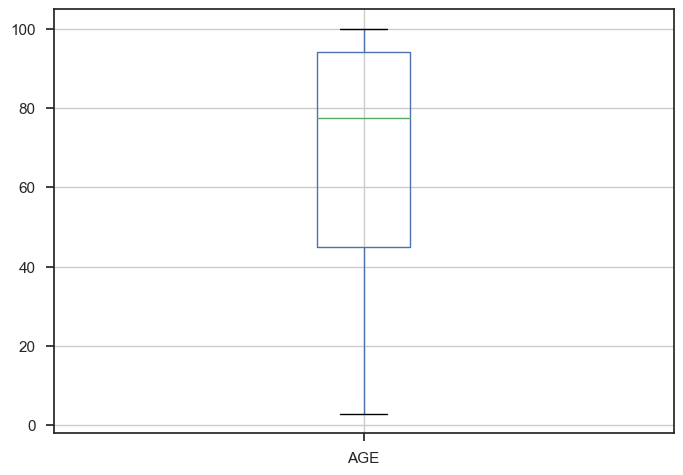

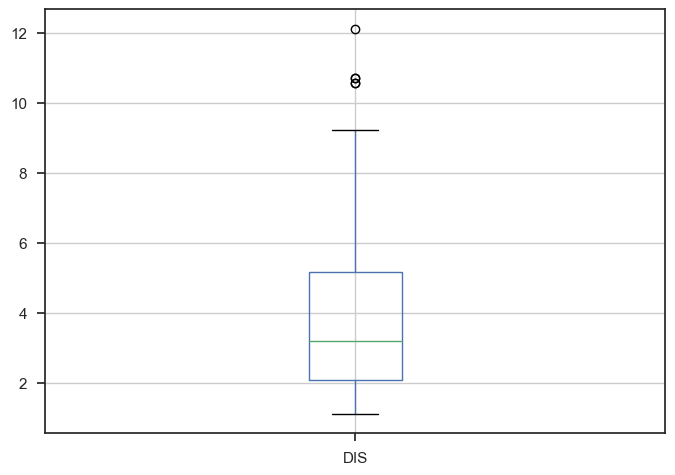

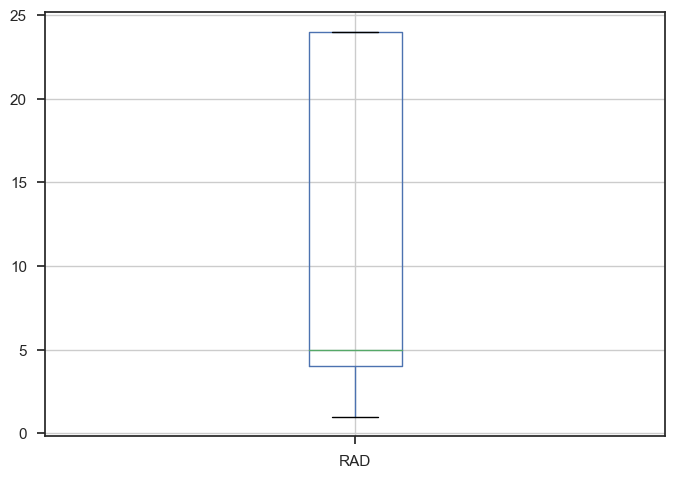

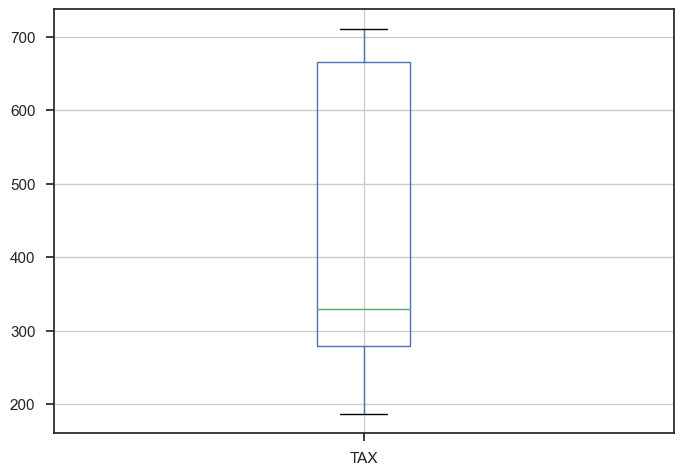

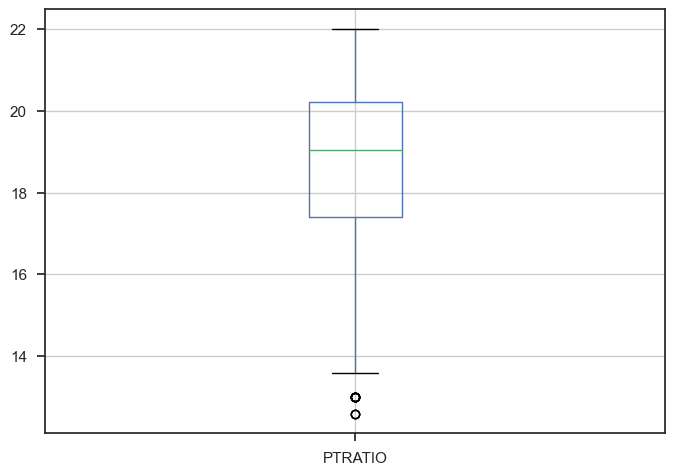

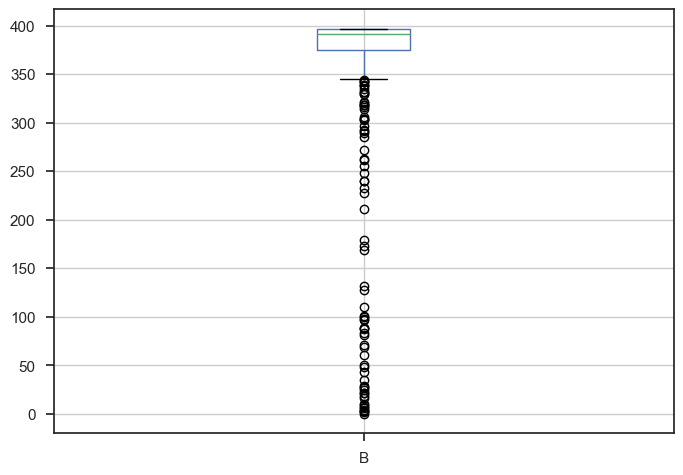

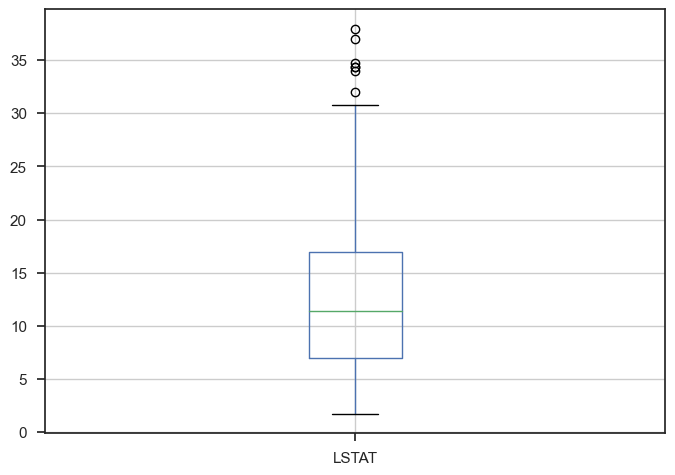

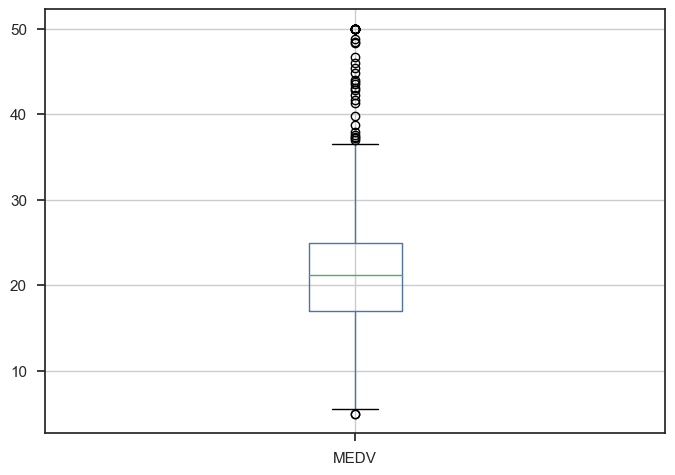

In [40]:
import matplotlib.pyplot as plt

for column in bostondf:
    plt.figure()
    bostondf.boxplot([column])

Text(0.5, 1.0, 'Pair Plots for Boston Housing')

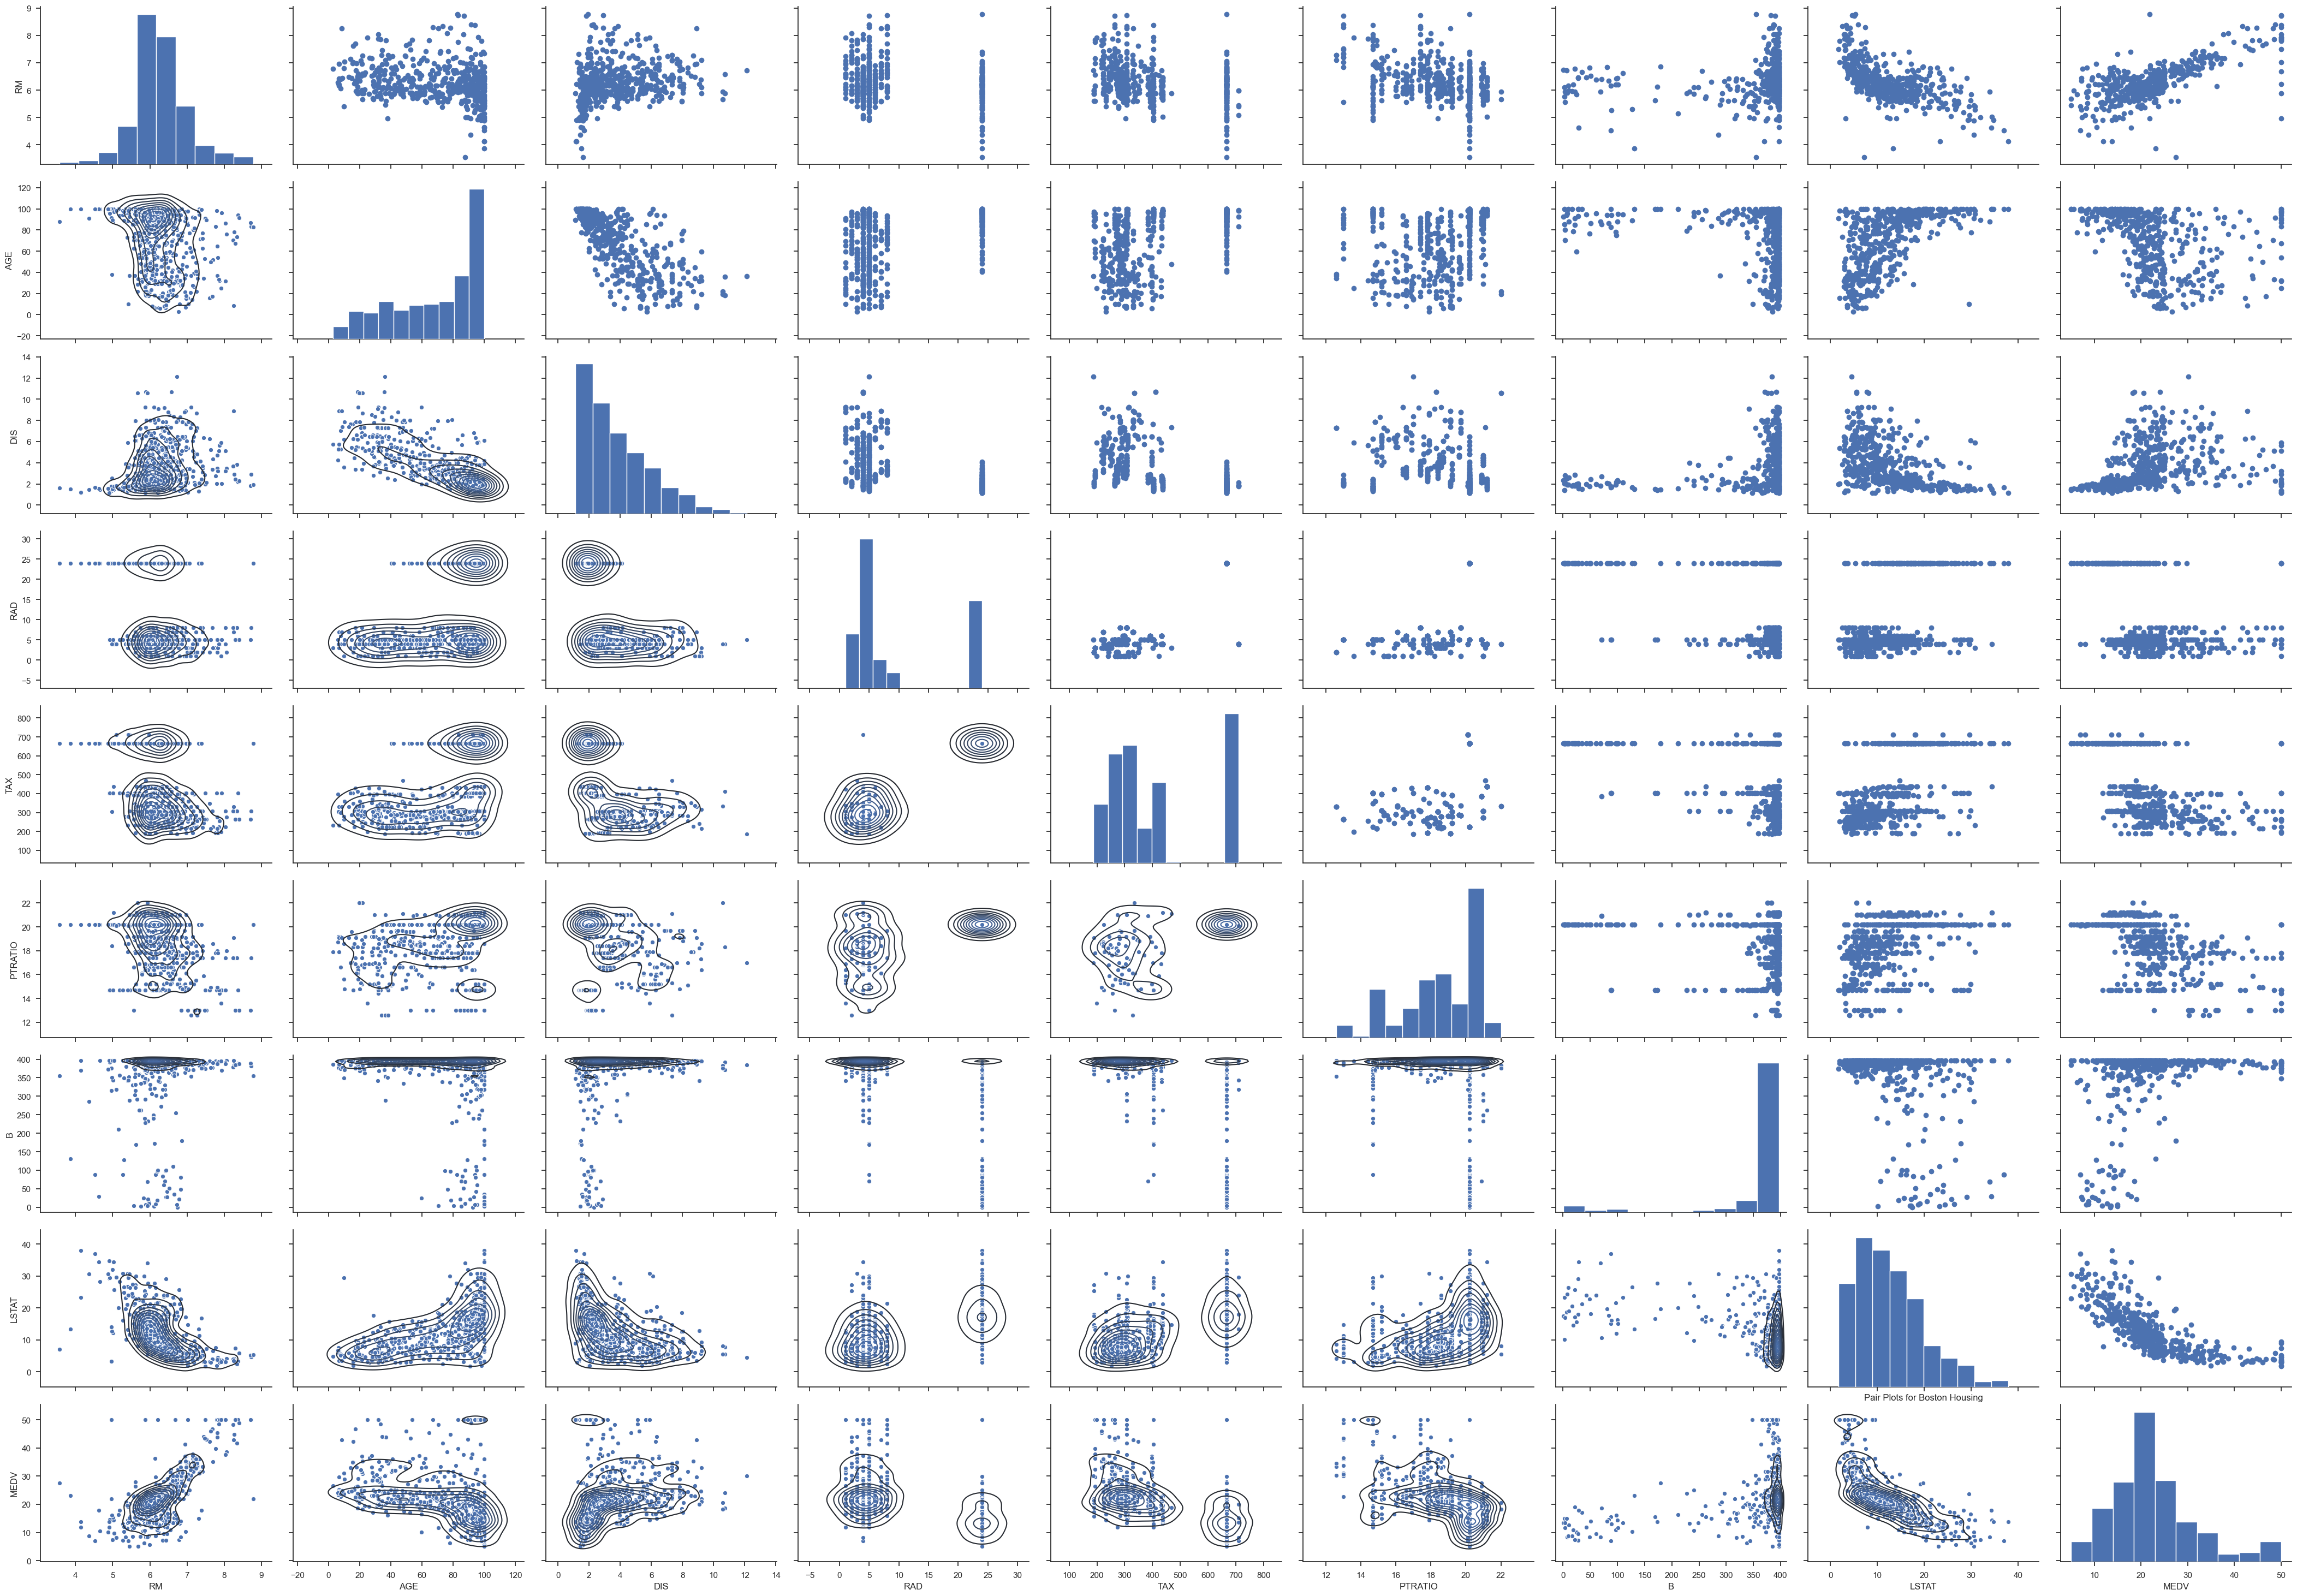

In [44]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(bostondf, vars=['RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT',  'MEDV'], height=3.27, aspect=4.7/3.27)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
#iris = sns.load_dataset("iris")8.7/8.27)
plt.title("Pair Plots for Boston Housing")

## Appendix: Training and Test Set Analysis

In [45]:
#pip install sweetviz
import sweetviz

my_report_analyze = sweetviz.analyze(bostondf)
my_report_compare = sweetviz.compare([train_set, "Baseline_Train"], [test_set, "Baseline_Test"], "NOX")
# my_report.to_notebook_iframe()
# my_report.to_file("BostonHousing_Baseline_EDA_Report.html")
my_report_analyze.show_html("Boston_EDA_Analyze_Report.html") # Not providing a filename will default to SWEETVIZ_REPORT.html
my_report_compare.show_html("Boston_EDA_Compare_Report.html") # Not providing a filename will default to SWEETVIZ_REPORT.html

ModuleNotFoundError: No module named 'sweetviz'

In [46]:
from IPython.display import IFrame
import os
os.getcwd()

IFrame(src='./Boston_EDA_Compare_Report.html', width=1000, height=1000)

from IPython.display import HTML
%%HTML
<p><img src = 'C:\Users\kevinm\Documents\GitHub\7333QTW\Case Study 5\MARvsMAR2V_Errors2.png'></img>
My image </p>

# HTML(filename='Boston_EDA_Compare_Report.html')
